<a href="https://colab.research.google.com/github/MarkAvilin1/DS-and-ML/blob/main/traffic_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**#Задание Ultra pro**

модель для прогнозирования трафика. 

In [ ]:
import numpy as np 
import pandas as pd 
from google.colab import drive
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

import warnings
warnings.filterwarnings("ignore")
# Рисовать графики сразу же
%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/University AI/traff.csv')
print(df.columns)
print(df.head())

Index(['1/1/2017', '22,226.00'], dtype='object')
   1/1/2017  22,226.00
0  1/2/2017  29,593.00
1  1/3/2017  31,726.00
2  1/4/2017  32,684.00
3  1/5/2017  31,820.00
4  1/6/2017  29,354.00


In [ ]:
df.columns = ['time', 'close']

for j in range(df.shape[1]):  
    for i in range(df.shape[0]): 
            df.values[i][j] = df.values[i][j].split('.')[0]
            df.values[i][j] = df.values[i][j].replace(",",".")

df['close'] = df['close'].astype(float)

print(df.columns)
print(df.head())

Index(['time', 'close'], dtype='object')
       time   close
0  1/2/2017  29.593
1  1/3/2017  31.726
2  1/4/2017  32.684
3  1/5/2017  31.820
4  1/6/2017  29.354


In [ ]:
print(df.columns)
print(df.head())
print(type(df['close'][0]))

Index(['time', 'close'], dtype='object')
       time   close
0  1/2/2017  29.593
1  1/3/2017  31.726
2  1/4/2017  32.684
3  1/5/2017  31.820
4  1/6/2017  29.354
<class 'numpy.float64'>


In [ ]:
xLen = 60
n_steps = 1
forvard_lag = 1

In [ ]:
for i in range(1, xLen + 1):
  indicator_name = f'delta{i}'
  df[indicator_name] = df['close'].pct_change(i)

print(df.shape)
print(df.head())

(1094, 62)
       time   close    delta1    delta2  ...  delta57  delta58  delta59  delta60
0  1/2/2017  29.593       NaN       NaN  ...      NaN      NaN      NaN      NaN
1  1/3/2017  31.726  0.072078       NaN  ...      NaN      NaN      NaN      NaN
2  1/4/2017  32.684  0.030196  0.104450  ...      NaN      NaN      NaN      NaN
3  1/5/2017  31.820 -0.026435  0.002963  ...      NaN      NaN      NaN      NaN
4  1/6/2017  29.354 -0.077498 -0.101885  ...      NaN      NaN      NaN      NaN

[5 rows x 62 columns]


In [ ]:
for i in range(1, xLen + 1):
  indicator_name = f'delta{i}'
  indicator_name_new = f'Y{i}'
  df[indicator_name_new] = 0
  df.loc[df[indicator_name] > 0 , indicator_name_new] = 1

for i in range(1, xLen + 1):
  del df[f'delta{i}']

del df['time']

print(df.shape)
print(df.head())

(1094, 61)
    close  Y1  Y2  Y3  Y4  Y5  Y6  Y7  ...  Y53  Y54  Y55  Y56  Y57  Y58  Y59  Y60
0  29.593   0   0   0   0   0   0   0  ...    0    0    0    0    0    0    0    0
1  31.726   1   0   0   0   0   0   0  ...    0    0    0    0    0    0    0    0
2  32.684   1   1   0   0   0   0   0  ...    0    0    0    0    0    0    0    0
3  31.820   0   1   1   0   0   0   0  ...    0    0    0    0    0    0    0    0
4  29.354   0   0   0   0   0   0   0  ...    0    0    0    0    0    0    0    0

[5 rows x 61 columns]


In [ ]:
data_Y = df[f"Y{xLen}"]
data_Y[:5]

0    0
1    0
2    0
3    0
4    0
Name: Y60, dtype: int64

In [ ]:
categorical_labels = to_categorical(data_Y, num_classes=2)
print(len(categorical_labels))
categorical_labels[:5]

1094


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
n_train = 200
xTrain = df[: -n_train - n_steps]
xTest = df[-n_train: ]
yTrain = categorical_labels[: -n_train - n_steps]
yTest = categorical_labels[-n_train: ]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape)
xTrain.shape[0] + xTest.shape[0]

xTrain:  (893, 61) 	yTrain: (893, 2) 
xTest:   (200, 61) 	yTest:  (200, 2)


1093

In [ ]:
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

(893, 61) (200, 61) <class 'numpy.ndarray'>


array([[ 1.4786201 , -0.78224891, -0.85476322, -0.91512216, -1.03999283,
        -1.09028688, -1.0283986 , -0.98114085, -0.87853594, -0.86461195,
        -0.896683  ,  1.03533847, -0.97238561, -0.93177295, -0.9486833 ,
        -0.88858267, -0.85084559, -0.86659125,  1.09275029, -0.91718979,
        -0.88455363, -0.88455363, -0.86659125, -0.86263586, -0.86461195,
         1.10766993,  1.12029037,  1.14868643, -0.85476322, -0.85672667,
        -0.87254869, -0.86263586, -0.88053842, -0.87254869, -0.84499202,
        -0.83722899, -0.83336496, -0.84499202, -0.84110462,  1.18072091,
         1.18072091,  1.2083274 ,  1.23393633, -0.82375447, -0.82951235,
        -0.83529554,  1.20273661,  1.19166027,  1.20552756,  1.2310536 ,
        -0.8066269 , -0.79908204, -0.81802132,  1.19441636,  1.19166027,
         1.18617372, -0.80851945, -0.78597304, -0.79157679, -0.81231232,
         1.21113617]])

In [ ]:
def split_sequence(sequence, Y, n_steps, forvard_lag):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # проверяем, чтобы не выйти за пределы массива
      break 
    seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
    X.append(seq_x)
    y.append(seq_y) # тк предсказываем только Close
  return np.array(X), np.array(y)

In [ ]:
for i in [forvard_lag]:
  xTrain, yTrain = split_sequence(xTrain, yTrain, n_steps, forvard_lag=i)

for i in [forvard_lag]:
  xTest, yTest = split_sequence(xTest, yTest, n_steps, forvard_lag=i)

In [ ]:
drop = 0.5
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
x = Flatten()(input)
x = RepeatVector(4)(x)
x = Conv1D(n_steps*2, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = RepeatVector(4)(x)
x = Conv1D(n_steps, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(n_steps*100, activation='elu')(x)
x = Dropout(drop)(x)
x = Dense(n_steps*400, activation='elu')(x)
x = Dropout(drop)(x)
x = Dense(n_steps*500, activation='relu')(x)
x = Dense(yTrain.shape[1], activation='sigmoid')(x)
model = Model(input, x)

In [ ]:
model.compile(optimizer=Adam(learning_rate = 5e-05),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(xTrain, yTrain, epochs=100, verbose = 1,
                    validation_data=(xTest, yTest))

Epoch 1/100
28/28 [==============================] - 1s 16ms/step - loss: 0.7046 - accuracy: 0.4910 - val_loss: 0.6436 - val_accuracy: 0.9045
Epoch 2/100
28/28 [==============================] - 0s 9ms/step - loss: 0.6942 - accuracy: 0.5381 - val_loss: 0.6300 - val_accuracy: 0.9095
Epoch 3/100
28/28 [==============================] - 0s 9ms/step - loss: 0.6898 - accuracy: 0.5258 - val_loss: 0.5728 - val_accuracy: 0.9095
Epoch 4/100
28/28 [==============================] - 0s 9ms/step - loss: 0.6683 - accuracy: 0.5717 - val_loss: 0.4764 - val_accuracy: 0.9146
Epoch 5/100
28/28 [==============================] - 0s 9ms/step - loss: 0.6389 - accuracy: 0.6491 - val_loss: 0.3965 - val_accuracy: 0.9146
Epoch 6/100
28/28 [==============================] - 0s 10ms/step - loss: 0.6111 - accuracy: 0.6984 - val_loss: 0.3466 - val_accuracy: 0.9146
Epoch 7/100
28/28 [==============================] - 0s 10ms/step - loss: 0.5993 - accuracy: 0.7231 - val_loss: 0.3266 - val_accuracy: 0.9146
Epoch 8/10

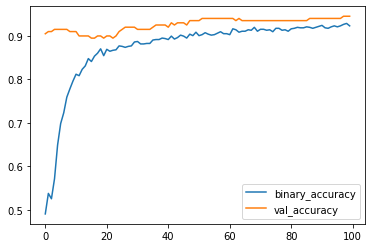

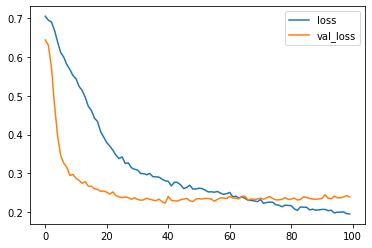

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='binary_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
x_test = xTest[-200:]
y_test_org = yTest[-200:]
true_answer = 0
for i in range(len(x_test)):  
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) 
 
  prediction = np.argmax(prediction) 

  if prediction == np.argmax(y_test_org[i]):
    true_answer+=1
  
  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])

quality = f"The quality is {int((true_answer / 200) * 100)} %"

print('Правильных ответов:', true_answer)
print('Ошибочных ответов:', 200 - true_answer)
print(quality)

Index: 0 	Prediction: 1 Real: 0 	====> [1. 0.]
Index: 1 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 2 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 3 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 4 	Prediction: 0 Real: 0 	====> [1. 0.]
Index: 5 	Prediction: 0 Real: 0 	====> [1. 0.]
Index: 6 	Prediction: 0 Real: 0 	====> [1. 0.]
Index: 7 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 8 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 9 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 10 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 11 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 12 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 13 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 14 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 15 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 16 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 17 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 18 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 19 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 20 	Prediction: 1 Real: 1 	====> [0. 1.]
In